In [1]:
import torch
is_cuda_enabled = torch.cuda.is_available()
print('Cuda enabled', is_cuda_enabled)
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

Cuda enabled True
0
1
Tesla T4


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset

import os
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt

In [3]:
RSNA_Dataset = '~/Data/RSNA/train.csv'
DDSM_Dataset = '~/Data/DDSM/mass_case_description_train_set.csv'
DDSM2_Dataset = '~/Data/DDSM2/train+ddsm.csv'

In [4]:
df_train = pd.read_csv(RSNA_Dataset)
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [69]:
cancer_pred = df_train.loc[df_train["cancer"]==0]
print(cancer_pred)

       site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0            2       10006   462822612          L   CC  61.0       0       0   
1            2       10006  1459541791          L  MLO  61.0       0       0   
2            2       10006  1864590858          R  MLO  61.0       0       0   
3            2       10006  1874946579          R   CC  61.0       0       0   
4            2       10011   220375232          L   CC  55.0       0       0   
...        ...         ...         ...        ...  ...   ...     ...     ...   
54701        1        9973  1729524723          R  MLO  43.0       0       0   
54702        1        9989    63473691          L  MLO  60.0       0       0   
54703        1        9989  1078943060          L   CC  60.0       0       0   
54704        1        9989   398038886          R  MLO  60.0       0       0   
54705        1        9989   439796429          R   CC  60.0       0       0   

       invasive  BIRADS  implant densit

In [5]:
df_train["cancer"].unique()

array([0, 1])

In [5]:
df_ddsm = pd.read_csv(DDSM_Dataset)
df_ddsm2 = pd.read_csv(DDSM2_Dataset)

In [6]:
df_ddsm.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [7]:
df_ddsm2.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2.0,10006,4.628226e+08,L,CC,61.0,0,0.0,0.0,NaN,0.0,NaN,29.0,False
1,2.0,10006,1.459542e+09,L,MLO,61.0,0,0.0,0.0,NaN,0.0,NaN,29.0,False
2,2.0,10006,1.864591e+09,R,MLO,61.0,0,0.0,0.0,NaN,0.0,NaN,29.0,False
3,2.0,10006,1.874947e+09,R,CC,61.0,0,0.0,0.0,NaN,0.0,NaN,29.0,False
4,2.0,10011,2.203752e+08,L,CC,55.0,0,0.0,0.0,0.0,0.0,NaN,21.0,True


## DDSM small EDA

In [9]:
print("Number of patient with malignant cancer in the ddsm dataset :", len(df_ddsm[df_ddsm['pathology']=="MALIGNANT"]))

Number of patient with malignant cancer in the ddsm dataset : 637


In [10]:
print("Number of patient with benign cancer in the ddsm dataset :", len(df_ddsm[df_ddsm['pathology']=="BENIGN"]))

Number of patient with benign cancer in the ddsm dataset : 577


In [11]:
print("Number of patient with neither benign nor malignant cancer in the ddsm dataset :", len(df_ddsm[(df_ddsm['pathology']!="BENIGN")& (df_ddsm['pathology']!="MALIGNANT")]))

Number of patient with neither benign nor malignant cancer in the ddsm dataset : 104


## DDSM2 small EDA

In [12]:
print("Number of patient with malignant cancer in the ddsm dataset :", len(df_ddsm2[df_ddsm2['cancer']==1]))

Number of patient with malignant cancer in the ddsm dataset : 2795


In [13]:
print("Number of patient with begnin cancer in the ddsm dataset :", len(df_ddsm2[df_ddsm2['cancer']==0]))

Number of patient with begnin cancer in the ddsm dataset : 54768


## New CSV with the with 2795 malginant cancer and 2800 begnin

In [14]:
benign_cases = df_ddsm2[df_ddsm2['cancer'] == 0]
malignant_cases = df_ddsm2[df_ddsm2['cancer'] == 1]

# Randomly select 2800 benign cases
benign_sample = benign_cases.sample(n=2800, random_state=42)

# Combine malignant cases with the selected benign cases
new_dataset = pd.concat([benign_sample, malignant_cases])


output_path = '~/Data/DDSM2/balanced_dataset.csv'
new_dataset.to_csv(output_path, index=False)

print(f"New dataset saved to {output_path}")


New dataset saved to ~/Data/DDSM2/balanced_dataset.csv


In [15]:
balanced_dataset = pd.read_csv("~/Data/DDSM2/balanced_dataset.csv")

In [16]:
print("Number of patient with malignant cancer in the ddsm dataset :", len(balanced_dataset[balanced_dataset['cancer']==1]))

Number of patient with malignant cancer in the ddsm dataset : 2795


In [17]:
print("Number of patient with malignant cancer in the ddsm dataset :", len(balanced_dataset[balanced_dataset['cancer']==0]))

Number of patient with malignant cancer in the ddsm dataset : 2800


In [6]:
read_ddsm2 = pd.read_csv("~/Data/DDSM2/balanced_dataset.csv")
read_ddsm2.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2.0,31862,7.257299e+07,R,MLO,63.0,0,0.0,0.0,NaN,0.0,NaN,48.0,False
1,2.0,30300,1.408897e+09,L,CC,55.0,0,0.0,0.0,NaN,0.0,NaN,48.0,False
2,2.0,55989,7.692952e+08,L,CC,72.0,0,0.0,0.0,NaN,0.0,NaN,21.0,False
3,1.0,24086,7.950168e+08,R,MLO,68.0,0,0.0,0.0,2.0,0.0,C,49.0,False
4,2.0,30480,8.368581e+07,R,CC,69.0,0,0.0,0.0,NaN,0.0,NaN,48.0,False


## RSNA small EDA

In [19]:
print("Number of patient :", len(df_train))

Number of patient : 54706


In [20]:
print("Non-malignat cancer :", len(df_train[df_train['cancer']== 0]))

Non-malignat cancer : 53548


In [21]:
print("Malignant cancer  :", len(df_train[df_train['cancer']== 1]))

Malignant cancer  : 1158


In [22]:
len(df_train[df_train['biopsy'] == 1])

2969

In [23]:
print("Patient with non invasive cancer :", len(df_train[df_train['invasive'] == 0]))

Patient with non invasive cancer : 53888


In [24]:
print("Patient with invasive cancer :", len(df_train[df_train['invasive'] == 1]))

Patient with invasive cancer : 818


In [25]:
print("Patient With malignat and invasive cancer :", len(df_train[(df_train['cancer']==0)&
                                                                  ((df_train['invasive']==1))]))

Patient With malignat and invasive cancer : 0


In [26]:
print("Patient With not-malignat and invasive cancer :", len(df_train[(df_train['cancer']==1)
                                                                      &((df_train['invasive']==1))]))

Patient With not-malignat and invasive cancer : 818


In [27]:
print("Patient with implant and not malignant cancer :", len(df_train[(df_train['implant']==1)&(df_train['cancer']==0)]))

Patient with implant and not malignant cancer : 1464


In [28]:
benign_cases = df_train[df_train['cancer'] == 0]
malignant_cases = df_train[df_train['cancer'] == 1]

# Randomly select 1200 benign cases
benign_sample = benign_cases.sample(n=1200, random_state=42)

# Combine malignant cases with the selected benign cases
new_dataset = pd.concat([benign_sample, malignant_cases])


output_path = '~/Data/balanced_dataset.csv'
new_dataset.to_csv(output_path, index=False)

print(f"New dataset saved to {output_path}")


New dataset saved to ~/Data/balanced_dataset.csv


In [6]:
dcmfnm = '/home/whif/Data/RSNA/train_images/10006/462822612.dcm'

ds = pydicom.dcmread(dcmfnm, force = True)
print("Display Meta Information\n", ds)

# Get information with keyword.
p_id = ds.PatientID
print("\n>Patient ID=", p_id, type(p_id))


Display Meta Information
 Dataset.file_meta -------------------------------
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.462822612
(0002,0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002,0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002,0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008,0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.462822612
(0008,0023) Content Date                        DA: '20221118'
(0008,0033) Content Time                        TM: '183901.561976'
(0010,0020) Patient ID                          LO: '10006'
(0020,000D) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0020,000E) Ser

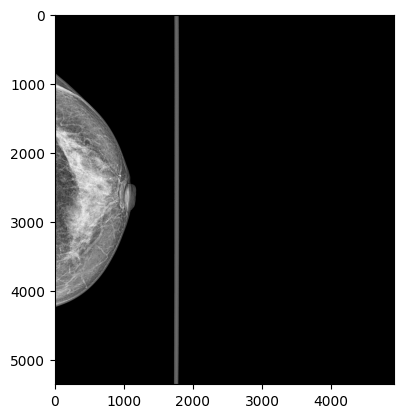

In [7]:
from PIL import Image, ImageOps
import cv2
image = ds.pixel_array
image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalize to [0, 1]
image = (image * 255).astype(np.uint8)  # Scale to [0, 255] for image processing

        # Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image = clahe.apply(image)  # Apply CLAHE to enhance contrast

        # Convert the image to a PIL Image for inversion
#image = Image.fromarray(image)

photometric_interpretation = ds.get('PhotometricInterpretation', None)

if photometric_interpretation == "MONOCHROME1":
        # If MONOCHROME1, invert the image (the maximum value will be black, and the minimum value will be white)
    image = 255 - image
    #image = ImageOps.invert(image)

plt.imshow(image, cmap='gray')

In [8]:
RSNA_path = '/home/whif/Data/RSNA/train_images'
RSNA_csv = pd.read_csv("~/Data/balanced_dataset.csv")
Balanced_RSNA_DDSM = pd.read_csv("~/Data/DDSM2/balanced_dataset.csv")
RSNA_DDSM_Path = '/home/whif/Data/DDSM2/full_images'

In [9]:
transform = transforms.Compose(
    [
     transforms.Resize((256,256)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(0.5)])

In [8]:


class RSNA_Dataset(Dataset):
    def __init__(self, img_data, img_path, transform = None):
        self.img_data = img_data
        self.img_path = img_path
        self.transform = transform
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(RSNA_path + '/' + str(self.img_data.loc[index, 'patient_id']) + '/' + str(self.img_data.loc[index, 'image_id']) + '.dcm')
        ds = pydicom.dcmread(img_name, force = True) # for DICOM data
        image = ds.pixel_array.astype(np.float32)
        # The data augmentation process begins.
        # Convert to PIL image.
        image = Image.fromarray(image)
        # random crop
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size = (256, 256))
        image = transforms.functional.crop(image, i, j, h, w)
        # Changing image laterality from R to L
        if ds.ImageLaterality == 'R':
            image = transforms.functional.hflip(image)
        # Convert back to NumPy array
        image = np.array(image)
        # The data augmentation process ends. It can be cut for validation data set.
        # resize
        image = np.resize(image, (300, 300))
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        label = torch.tensor(self.img_data.loc[index, 'cancer'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label



In [10]:
class RSNA_Dataset_Visual(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_data = img_data
        self.img_path = img_path
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, str(self.img_data.loc[index, 'patient_id']), str(self.img_data.loc[index, 'image_id']) + '.dcm')
        ds = pydicom.dcmread(img_name, force=True)
        image = ds.pixel_array.astype(np.float32)
        image = np.repeat(image[np.newaxis, :, :], 3, axis=0)  # Ensure 3 channels
        image = torch.tensor(image)  # Convert to tensor

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.img_data.loc[index, 'cancer'], dtype=torch.long)  # Use integer for CrossEntropyLoss
        return image, label

In [11]:


dataset_visual = RSNA_Dataset_Visual(RSNA_csv, RSNA_path, transform)


In [51]:


dataset_visual = RSNA_Dataset_Visual(Balanced_RSNA_DDSM, RSNA_DDSM_Path, transform)

In [12]:
len(dataset_visual)

2358

In [13]:
train, val = torch.utils.data.random_split(dataset = dataset_visual,
                                                         lengths = [2000,358], generator = torch.Generator().manual_seed(42))

In [14]:
def img_display(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    #npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

TypeError: Invalid shape (3, 256, 256) for image data

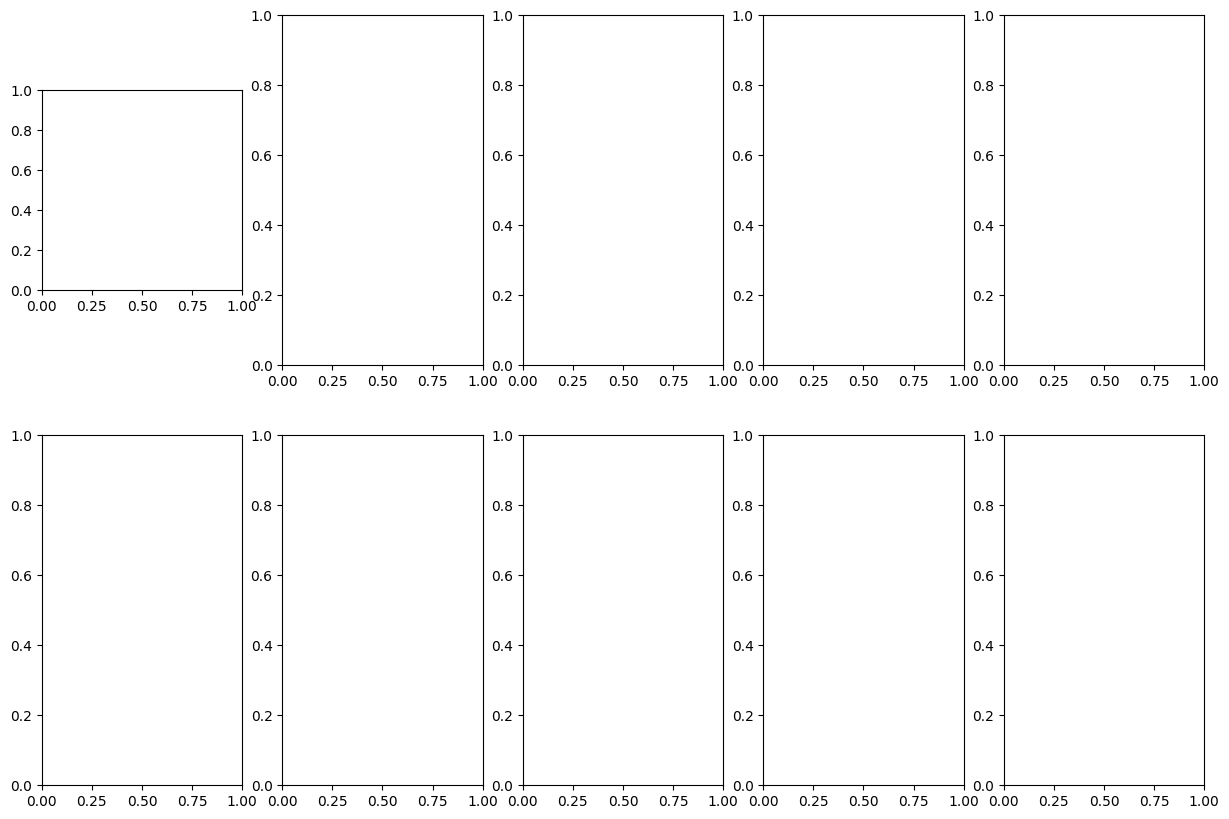

In [17]:


arthopod_types = {0: 'Not Malignant', 1: 'Malignant Cancer'}
# viewing data examples used for training
fig, axis = plt.subplots(2, 5, figsize = (15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = train[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label



In [14]:
train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle = False, drop_last = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 128)


In [15]:
from torchvision.models import vgg16_bn, VGG16_BN_Weights

In [16]:
vgg16_bn_weights = VGG16_BN_Weights.DEFAULT
model = vgg16_bn(weights=vgg16_bn_weights)

In [17]:
for params in model.parameters():
    params.requires_grad = False
        
    # Modify the classifier to adapt to the number of classes
    num_features = model.classifier[6].in_features
    features = list(model.classifier.children())[:-1]
    features.extend([torch.nn.Linear(num_features, 2)])
    model.classifier = torch.nn.Sequential(*features)

In [18]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor = 1, end_factor = 0.1, total_iters = 8)

In [19]:
n_epochs = 10
valid_loss_min = np.inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)

# Training loop
for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    model.train()  # Ensure model is in training mode

    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to("cuda"), target_.to("cuda")  # On GPU

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(data_)
        pred = torch.sigmoid(outputs)
        target = target_.unsqueeze(1).float()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        pred = pred > 0.40  # Normally 0.5
        accuracy = (target == pred).sum().item() / target.size(0)

        if (batch_idx) % 3 == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Step [{batch_idx}/{total_step}], Loss: {loss.item():.4f}')

    train_acc.append(100 * accuracy)
    train_loss.append(running_loss / total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * accuracy):.4f}')

    batch_loss = 0
    total_t = 0
    correct_t = 0

    # Validation
    with torch.no_grad():
        model.eval()
        for data_t, target_t in val_loader:
            data_t, target_t = data_t.to("cuda"), target_t.to("cuda")  # On GPU
            outputs_t = model(data_t)
            pred_t = torch.sigmoid(outputs_t)
            target_t = target_t.unsqueeze(1).float()
            loss_t = criterion(pred_t, target_t)
            batch_loss += loss_t.item()
            pred_t = pred_t > 0.40  # Normally 0.5
            accuracy_t = (target_t == pred_t).sum().item() / target_t.size(0)

        val_acc.append(100 * accuracy_t)
        val_loss.append(batch_loss / len(val_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * accuracy_t):.4f}\n')

        # Saving the best weight
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'cancer_classification.pt')
            print('Detected network improvement, saving current model')

    # Step the scheduler after the epoch
    scheduler.step()


Epoch 1



TypeError: Unexpected type <class 'numpy.ndarray'>